# October Census Analysis

In [1]:
import polars as pl
import requests
import tempfile
import os
from pathlib import Path
import re


In [38]:
df = pl.read_parquet("../data/historical/transportation_data_version_108.parquet")

In [6]:
null_summary = (
    df.select([
        ((pl.col(col).is_null().sum() / pl.len()) * 100).alias(col)
        for col in df.columns
    ])
    .unpivot(variable_name="column", value_name="null_percentage")
    .sort("null_percentage", descending=True)
)



In [8]:
null_summary.head(10)

column,null_percentage
str,f64
"""fax""",75.22867
"""dba_name""",73.398447
"""vmt_source_id""",59.122883
"""mcs150_mileage_year""",37.624305
"""mcs150_mileage""",34.438532
"""email_address""",23.97662
"""mcs150_date""",8.115175
"""nbr_power_unit""",3.802176
"""telephone""",0.549698


In [40]:
df = df.with_columns([
    pl.col("mcs150_mileage").is_null().alias("is_mcs150_mileage_null"),
    pl.col("mcs150_mileage_year").is_null().alias("is_mcs150_mileage_year_null"),
    pl.col("mcs150_date").is_null().alias("is_mcs150_date_null"),
    (pl.col("recent_mileage") == 0).alias("is_recent_mileage_zero"),
    (pl.col("recent_mileage_year") == 0).alias("is_recent_mileage_year_zero"),
])

In [41]:
df.group_by("vmt_source_id").agg([
          pl.mean("is_mcs150_mileage_null").alias("mcs150_mileage_null_rate"),
          pl.mean("is_mcs150_mileage_year_null").alias("mcs150_mileage_year_null_rate"),
          pl.mean("is_mcs150_date_null").alias("mcs150_date_null_rate"),
          pl.mean("is_recent_mileage_zero").alias("recent_mileage_zero_rate"),
          pl.mean("is_recent_mileage_year_zero").alias("recent_mileage_year_zero_rate"),
         
          pl.len().alias("n_rows")
      ]).sort("vmt_source_id")

vmt_source_id,mcs150_mileage_null_rate,mcs150_mileage_year_null_rate,mcs150_date_null_rate,recent_mileage_zero_rate,recent_mileage_year_zero_rate,n_rows
i64,f64,f64,f64,f64,f64,u32
null,0.581706,0.635132,0.136667,0.999998,0.999998,1236454
1,0.0,0.000227,0.000602,0.0,0.0,840289
2,0.108911,0.153846,0.018279,0.0,0.0,1313
3,0.062307,0.086115,0.015294,0.0,0.0,13273


In [18]:
df.filter(pl.col("vmt_source_id").is_not_null()).select(
    (pl.col("mcs150_mileage") == pl.col("recent_mileage")).mean().alias("pct_same_mileage"),
    (pl.col("mcs150_mileage_year") == pl.col("recent_mileage_year")).mean().alias("pct_same_year"),
)

pct_same_mileage,pct_same_year
f64,f64
0.986418,0.984977


In [20]:
(
    df.filter(pl.col("vmt_source_id").is_not_null())
      .with_columns(
          (pl.col("mcs150_mileage") == pl.col("recent_mileage")).alias("same_mileage")
      )
      .group_by("vmt_source_id")
      .agg([
          pl.mean("same_mileage").alias("pct_same_mileage"),
          pl.len().alias("n_rows")
      ])
)


vmt_source_id,pct_same_mileage,n_rows
i64,f64,u32
1,1.0,840289
3,0.161417,13273
2,0.007692,1313


In [22]:
df.describe()

statistic,phy_state,phy_country,phy_zip,phy_street,mailing_street,carrier_operation,phy_city,oic_state,email_address,mailing_city,mailing_zip,vmt_source_id,recent_mileage_year,mailing_state,mailing_country,mcs150_mileage_year,dba_name,legal_name,migrant,private_only,mcs150_mileage,telephone,exempt_for_hire,recent_mileage,hm_flag,private_property,state_government,fax,nbr_power_unit,dot_number,authorized_for_hire,federal_government,pc_flag,local_government,us_mail,op_other,private_passenger_nonbusiness,indian_tribe,private_passenger_business,driver_total,add_date,mcs150_date,version,is_mcs150_mileage_null,is_mcs150_mileage_year_null,is_mcs150_date_null,is_recent_mileage_null,is_recent_mileage_year_null
str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64
"""count""","""2089772""","""2091329""","""2089731""","""2089772""","""2089742""","""2091329""","""2089772""","""2091329""","""1589899""","""2089742""","""2089735""",854875.0,2.091329e6,"""2089742""","""2089742""",1.304481e6,"""556326""","""2091328""",2.091329e6,2.091329e6,1.371106e6,"""2079833""",2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,"""518050""",2.011813e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,"""2091273""",2.091329e6,2.091329e6,2.091329e6,2.088427e6,"""2091329""","""1921614""",2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6
"""null_count""","""1557""","""0""","""1598""","""1557""","""1587""","""0""","""1557""","""0""","""501430""","""1587""","""1594""",1.236454e6,0.0,"""1587""","""1587""",786848.0,"""1535003""","""1""",0.0,0.0,720223.0,"""11496""",0.0,0.0,0.0,0.0,0.0,"""1573279""",79516.0,0.0,0.0,0.0,0.0,0.0,0.0,"""56""",0.0,0.0,0.0,2902.0,"""0""","""169715""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,null,null,null,null,null,null,1.032588,827.091888,null,null,2021.874695,null,null,0.000409,0.368065,331036.035767,null,0.065152,170267.765972,0.004108,0.442085,0.003093,null,41.035,2.7040e6,0.562198,0.001844,0.017602,0.00304,0.002592,null,0.010084,0.000527,0.017721,6.187387,null,null,108.0,0.344385,0.376243,0.081152,0.0,0.0
"""std""",null,null,null,null,null,null,null,null,null,null,null,0.250158,997.010157,null,null,147.508666,null,null,null,null,2.0848e7,null,null,1.3891e7,null,null,null,null,2814.982202,1.1671e6,null,null,null,null,null,null,null,null,null,367.965082,null,null,0.0,null,null,null,null,null
"""min""","""AB""","""BZ""","""0000""","""# 1 CAVE INDUSTRIAL DRIVE""","""# 1 CAVE INDUSTRIAL DRIVE""","""A""","""-----BR""","""AK""","""!@""","""-----""","""0000""",1.0,0.0,"""AB""","""AZ""",0.0,"""#1""","""#1 TRUCK DOCTORS""",0.0,0.0,0.0,"""( 3) 039-1812""",0.0,0.0,0.0,0.0,0.0,"""( ) - 0""",0.0,1.0,0.0,0.0,0.0,0.0,0.0,"""#2 HEATING OIL""",0.0,0.0,0.0,0.0,"""01-APR-00""","""01-APR-01""",108.0,0.0,0.0,0.0,0.0,0.0
"""25%""",null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,null,2020.0,null,null,null,null,2800.0,null,null,0.0,null,null,null,null,1.0,1.768072e6,null,null,null,null,null,null,null,null,null,1.0,null,null,108.0,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,null,2023.0,null,null,null,null,20000.0,null,null,0.0,null,null,null,null,1.0,2.760819e6,null,null,null,null,null,null,null,null,null,1.0,null,null,108.0,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,1.0,2023.0,null,null,2024.0,null,null,null,null,79851.0,null,null,17183.0,null,null,null,null,2.0,3.728984e6,null,null,null,null,null,null,null,null,null,2.0,null,null,108.0,null,null,null,null,null
"""max""","""ZA""","""US""","""Y1A 8C4""","""ZUAZUA OTE 324""","""ZONA INDUSTRIAL JULIO N MATOS""","""C""","""ZYPHERHILLS""","""XX""","""��SANTIAGO@SVCRUZ.COM""","""ZYPHERHILLS""","""Y1A 6M8""",3.0,9999.0,"""ZA""","""WS""",9999.0,"""`""","""ZZZZZ'S MOVING LLC""",1.0,1.0,9.5372e9,"""(9

In [24]:
df.select(pl.all().exclude(pl.String)).describe()

statistic,vmt_source_id,recent_mileage_year,mcs150_mileage_year,migrant,private_only,mcs150_mileage,exempt_for_hire,recent_mileage,hm_flag,private_property,state_government,nbr_power_unit,dot_number,authorized_for_hire,federal_government,pc_flag,local_government,us_mail,private_passenger_nonbusiness,indian_tribe,private_passenger_business,driver_total,version,is_mcs150_mileage_null,is_mcs150_mileage_year_null,is_mcs150_date_null,is_recent_mileage_null,is_recent_mileage_year_null
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",854875.0,2.091329e6,1.304481e6,2.091329e6,2.091329e6,1.371106e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.011813e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.088427e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6,2.091329e6
"""null_count""",1.236454e6,0.0,786848.0,0.0,0.0,720223.0,0.0,0.0,0.0,0.0,0.0,79516.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2902.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.032588,827.091888,2021.874695,0.000409,0.368065,331036.035767,0.065152,170267.765972,0.004108,0.442085,0.003093,41.035,2.7040e6,0.562198,0.001844,0.017602,0.00304,0.002592,0.010084,0.000527,0.017721,6.187387,108.0,0.344385,0.376243,0.081152,0.0,0.0
"""std""",0.250158,997.010157,147.508666,null,null,2.0848e7,null,1.3891e7,null,null,null,2814.982202,1.1671e6,null,null,null,null,null,null,null,null,367.965082,0.0,null,null,null,null,null
"""min""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0
"""25%""",1.0,0.0,2020.0,null,null,2800.0,null,0.0,null,null,null,1.0,1.768072e6,null,null,null,null,null,null,null,null,1.0,108.0,null,null,null,null,null
"""50%""",1.0,0.0,2023.0,null,null,20000.0,null,0.0,null,null,null,1.0,2.760819e6,null,null,null,null,null,null,null,null,1.0,108.0,null,null,null,null,null
"""75%""",1.0,2023.0,2024.0,null,null,79851.0,null,17183.0,null,null,null,2.0,3.728984e6,null,null,null,null,null,null,null,null,2.0,108.0,null,null,null,null,null
"""max""",3.0,9999.0,9999.0,1.0,1.0,9.5372e9,1.0,9.5372e9,1.0,1.0,1.0,1.299987e6,4.473354e6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,199998.0,108.0,1.0,1.0,1.0,0.0,0.0


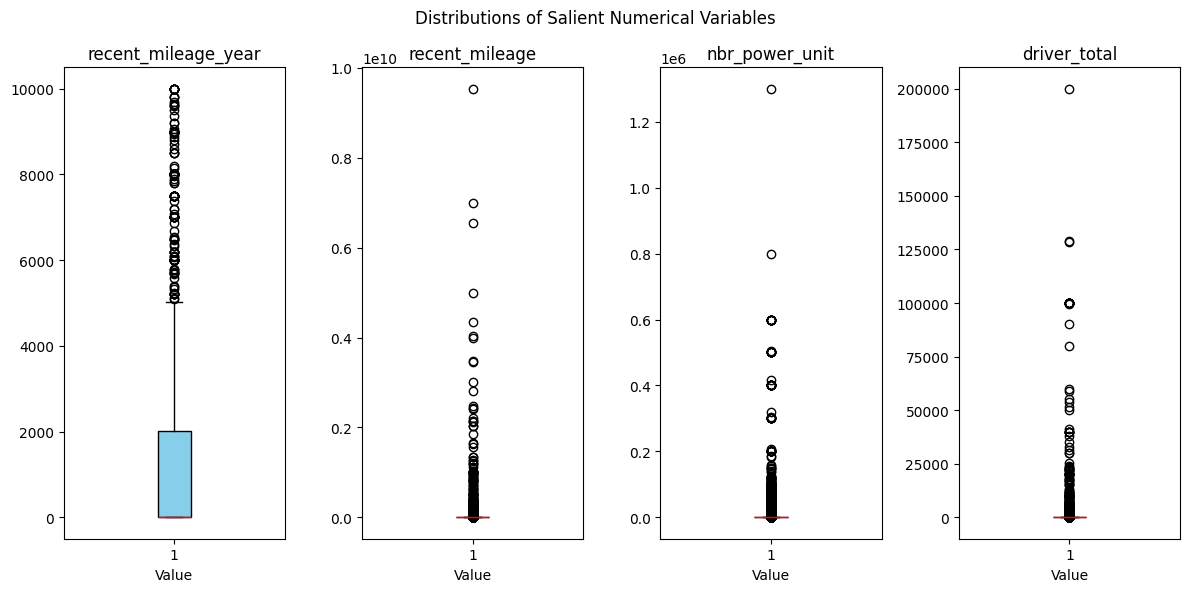

In [35]:
import matplotlib.pyplot as plt

numerics = [
    'recent_mileage_year', 
    'recent_mileage', 
    'nbr_power_unit', 
    'driver_total'
]

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(numerics):
    axes[i].boxplot(df[col].drop_nulls().to_numpy(),
                    patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")

fig.suptitle("Distributions of Salient Numerical Variables")
plt.tight_layout()
plt.show()
fig.savefig("numeric_boxplots.png", dpi=300, bbox_inches="tight")


In [36]:
df.select(numerics).describe()

statistic,recent_mileage_year,recent_mileage,nbr_power_unit,driver_total
str,f64,f64,f64,f64
"""count""",2.091329e6,2.091329e6,2.011813e6,2.088427e6
"""null_count""",0.0,0.0,79516.0,2902.0
"""mean""",827.091888,170267.765972,41.035,6.187387
"""std""",997.010157,1.3891e7,2814.982202,367.965082
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,1.0,1.0
"""50%""",0.0,0.0,1.0,1.0
"""75%""",2023.0,17183.0,2.0,2.0
"""max""",9999.0,9.5372e9,1.299987e6,199998.0


In [42]:
df = df.with_columns([
    pl.when(pl.col("nbr_power_unit") > 0)
      .then(pl.col("driver_total") / pl.col("nbr_power_unit"))
      .otherwise(None)
      .alias("drivers_per_unit")
])

In [43]:
df["drivers_per_unit"].describe()

statistic,value
str,f64
"""count""",1.963057e6
"""null_count""",128272.0
"""mean""",2.216003
"""std""",233.641906
"""min""",0.0
"""25%""",1.0
"""50%""",1.0
"""75%""",1.0
"""max""",100000.0


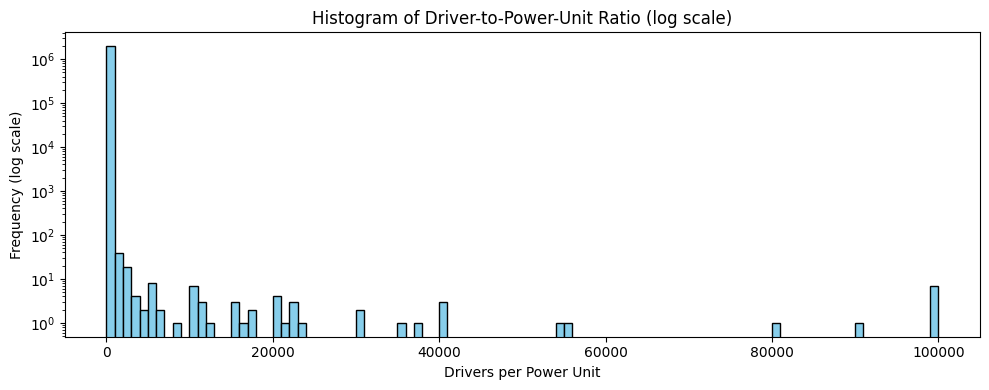

In [76]:
import numpy as np

ratio = df["drivers_per_unit"].drop_nulls().to_numpy()

fig, axes = plt.subplots(1, 1, figsize=(10, 4))

axes.hist(ratio, bins=100, color='skyblue', edgecolor='black', log=True)
axes.set_xlabel("Drivers per Power Unit")
axes.set_ylabel("Frequency (log scale)")
axes.set_title("Histogram of Driver-to-Power-Unit Ratio (log scale)")


plt.tight_layout()
plt.show()

fig.savefig("ndriver-ratio.png", dpi=300, bbox_inches="tight")
fig.savefig("driver-ratio.svg", bbox_inches="tight")


In [49]:
df = df.with_columns([
    pl.when(pl.col("nbr_power_unit") > 0)
      .then(pl.col("recent_mileage") / pl.col("nbr_power_unit"))
      .otherwise(None)
      .alias("mileage_per_truck"),
    pl.when(pl.col("driver_total") > 0)
      .then(pl.col("recent_mileage") / pl.col("driver_total"))
      .otherwise(None)
      .alias("mileage_per_driver"),
])

In [56]:
df.select("^mileage_per.*$").describe()


statistic,mileage_per_truck,mileage_per_driver
str,f64,f64
"""count""",1.964203e6,2.074498e6
"""null_count""",127126.0,16831.0
"""mean""",45286.609584,47951.734944
"""std""",8.1465e6,1.0828e7
"""min""",0.0,0.0
"""25%""",0.0,0.0
"""50%""",0.0,0.0
"""75%""",10000.0,10000.0
"""max""",7.0000e9,9.5372e9


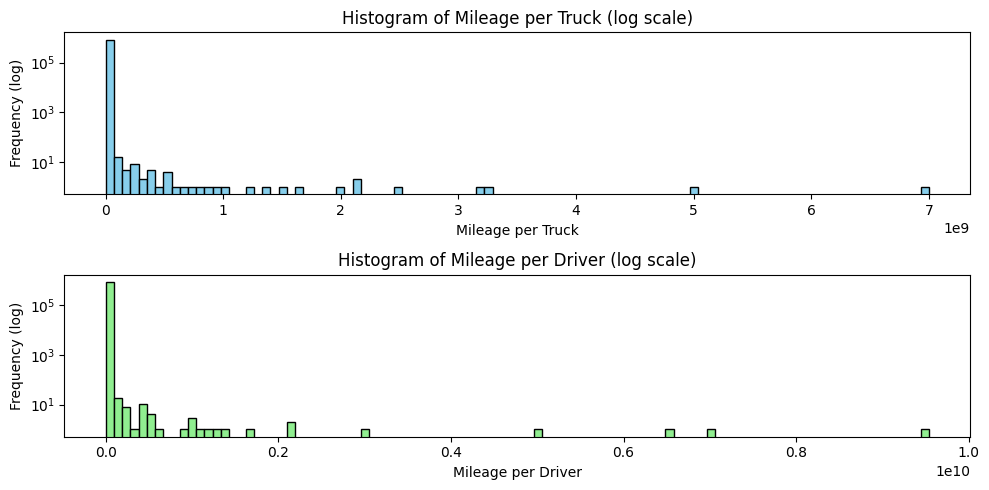

In [77]:
mileage_truck = df["mileage_per_truck"].drop_nulls().to_numpy()
mileage_driver = df["mileage_per_driver"].drop_nulls().to_numpy()

clip_value = 200_000 
mileage_truck_clipped = np.clip(mileage_truck, 0, clip_value)
mileage_driver_clipped = np.clip(mileage_driver, 0, clip_value)

fig, axes = plt.subplots(2, 1, figsize=(10, 5))

axes[0].hist(mileage_truck[mileage_truck>0], bins=100, color='skyblue', edgecolor='black', log=True)
axes[0].set_title("Histogram of Mileage per Truck (log scale)")
axes[0].set_xlabel("Mileage per Truck")
axes[0].set_ylabel("Frequency (log)")

axes[1].hist(mileage_driver[mileage_driver>0], bins=100, color='lightgreen', edgecolor='black', log=True)
axes[1].set_title("Histogram of Mileage per Driver (log scale)")
axes[1].set_xlabel("Mileage per Driver")
axes[1].set_ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

fig.savefig("mileage-ratio.png", dpi=300, bbox_inches="tight")
fig.savefig("mileage-ratio.svg", bbox_inches="tight")


In [75]:
import seaborn as sns
from functools import reduce


thresholds = {
    "drivers_per_unit": 20,       
    "mileage_per_truck": 200_000, 
    "mileage_per_driver": 200_000 
}


df = df.with_columns([
    (pl.col("drivers_per_unit") > thresholds["drivers_per_unit"]).alias("drivers_per_unit_outlier"),
    (pl.col("mileage_per_truck") > thresholds["mileage_per_truck"]).alias("mileage_per_truck_outlier"),
    (pl.col("mileage_per_driver") > thresholds["mileage_per_driver"]).alias("mileage_per_driver_outlier"),
])

df = df.with_columns([
    (
        pl.col("drivers_per_unit_outlier").cast(pl.Int8) +
        pl.col("mileage_per_truck_outlier").cast(pl.Int8) +
        pl.col("mileage_per_driver_outlier").cast(pl.Int8)
    ).alias("nonsense_score")
])

# 3️⃣ Quick stats
df["nonsense_score"].value_counts(normalize=True)

nonsense_score,proportion
i8,f64
2,0.009046
1,0.003201
null,0.064398
0,0.923355
